# Word2Vec之Skip-Gram模型实战-中文文本版

下面代码将用TensorFlow实现Word2Vec中的Skip-Gram模型。

> 使用的是爬取的某IT招聘网站的招聘信息训练词向量
1. 导包
2. 加载数据
3. 数据预处理
4. 数据采样
5. 训练数据构造
6. 网络的构建
7. 训练
8. 可视化

# 1 导入包

In [1]:
import time
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from collections import Counter

In [71]:
tf.__version__

'1.12.0'

# 2 加载数据

数据集使用的是爬取的某IT招聘网站的招聘信息，数据已经进行切词处理，2944万词。

In [72]:
df=pd.read_csv('data/AutoMaster_Corpus.csv',header=None).rename(columns={0:'text'})

In [73]:
df.head()

,text
0,方向机 重 ， 助力 泵 ， 方向机 都 换 技师说 车主说 新 都 换 车主说 助力 泵 ...
1,奔驰 ML500 排气 凸轮轴 调节 错误 技师说 有没有 电脑 检测 故障 代码 。 车主...
2,2010 款 宝马X1 ， 2011 年 出厂 ， 2.0 排量 ， 通用 6L45 变速箱...
3,3.0 V6 发动机 号 位置 ， 照片 最好 ！ 技师说 右侧 排气管 上方 ， 缸体 上...
4,2012 款 奔驰 c180 ， 维修保养 ， 动力 ， 值得 拥有 技师说 家庭 用车 ，...


In [28]:
text=' '.join(df['text'])

In [3]:
# with open('data/Javasplittedwords') as f:
#     text = f.read()

In [75]:
words=text.split(' ')

In [76]:
len(words)

12964752

In [78]:
text[:100]

'方向机 重 ， 助力 泵 ， 方向机 都 换 技师说 车主说 新 都 换 车主说 助力 泵 ， 方向机 技师说 车主说 换 方向机 带 车主说 技师说 车主说 助力 重 ， 这车 匹配 技师说 不 需'

# 3 数据预处理

数据预处理过程主要包括：

- 替换文本中特殊符号并去除低频词
- 对文本分词
- 构建语料
- 单词映射表

首先我们定义一个函数来完成前两步，即对文本的清洗和分词操作。

In [79]:
# 定义函数来完成数据的预处理
def preprocess(text, freq=50):
    '''
    对文本进行预处理
    
    参数
    ---
    text: 文本数据
    freq: 词频阈值
    '''
    # 对文本中的符号进行替换
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace('。', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('，', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    
    # 删除低频词，减少噪音影响
    word_counts = Counter(words)
    
    trimmed_words = [word for word in words if word_counts[word] > freq]

    return trimmed_words

上面的函数实现了替换标点及删除低频词操作，返回分词后的文本。

下面让我们来看看经过清洗后的数据:

In [80]:
# 清洗文本并分词
words = preprocess(text)
print(words[:20])

['方向机', '重', '<COMMA>', '助力', '泵', '<COMMA>', '方向机', '都', '换', '技师说', '车主说', '新', '都', '换', '车主说', '助力', '泵', '<COMMA>', '方向机', '技师说']


有了分词后的文本，就可以构建我们的映射表。

In [81]:
# 构建映射表
vocab = set(words)

In [82]:
len(vocab)

8408

In [83]:
vocab_to_int = {word: index for index, word in enumerate(vocab)}
int_to_vocab = {index: word for index, word in enumerate(vocab)}

In [36]:
int_to_vocab = {index: word for index, word in enumerate(vocab)}

In [86]:
print("total words: {}".format(len(words)))
print("unique words: {}".format(len(set(words))))

total words: 12565768
unique words: 8408


整个文本中单词大约为800万的规模，词典大小为6000左右，这个规模对于训练好的词向量其实是不够的，但可以训练出一个稍微还可以的模型。

In [87]:
# 对原文本进行vocab到int的转换
int_words = [vocab_to_int[w] for w in words]

# 4 采样

我们知道`skip-gram`中，训练样本的形式是`(input word, output word)`，其中`output word`是`input word`的上下文。为了减少模型噪音并加速训练速度，我们在构造`batch`之前要对样本进行采样，剔除停用词等噪音因素。

对停用词进行采样，例如“你”， “我”以及“的”这类单词进行剔除。剔除这些单词以后能够加快我们的训练过程，同时减少训练过程中的噪音。

我们采用以下公式:
$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

其中$ t $是一个阈值参数，一般为1e-3至1e-5。  
$f(w_i)$ 是单词 $w_i$ 在整个数据集中的出现频次。  
$P(w_i)$ 是单词被删除的概率。

>这个公式和论文中描述的那个公式有一些不同

In [89]:
int_word_counts = Counter(int_words)

In [90]:
t = 1e-3 # t值
threshold = 0.7 # 剔除概率阈值

# 统计单词出现频次
int_word_counts = Counter(int_words)
total_count = len(int_words)
# 计算单词频率
word_freqs = {w: c/total_count for w, c in int_word_counts.items()}
# 计算被删除的概率
prob_drop = {w: 1 - np.sqrt(t / word_freqs[w]) for w in int_word_counts}
# 对单词进行采样
train_words = [w for w in int_words if prob_drop[w] < threshold]

In [91]:
drop_words=[int_to_vocab[w] for w in int_words if prob_drop[w] > threshold]

In [92]:
set(drop_words)

{'<COMMA>', '<PERIOD>', '技师说', '车主说', '问题', '？'}

上面的代码计算了样本中每个单词被删除的概率，并基于概率进行了采样，现在我们手里就拿到了采样过的单词列表。

In [93]:
len(int_words)

12565768

In [94]:
len(train_words)

9346018

In [95]:
int_words

[2667,
 6438,
 2036,
 4046,
 896,
 2036,
 2667,
 6324,
 8206,
 3724,
 6187,
 6834,
 6324,
 8206,
 6187,
 4046,
 896,
 2036,
 2667,
 3724,
 6187,
 8206,
 2667,
 4468,
 6187,
 3724,
 6187,
 4046,
 6438,
 2036,
 1651,
 5278,
 3724,
 3043,
 2720,
 3724,
 4560,
 6144,
 3557,
 6187,
 8157,
 7087,
 5701,
 7208,
 2036,
 7517,
 6438,
 549,
 7141,
 3724,
 7526,
 6438,
 6187,
 2036,
 3724,
 6187,
 4847,
 2036,
 8083,
 6274,
 2615,
 6438,
 2036,
 4704,
 4797,
 896,
 8206,
 6802,
 2036,
 4602,
 6854,
 2036,
 8087,
 985,
 3043,
 4246,
 8083,
 4168,
 7141,
 3724,
 3724,
 4745,
 3518,
 7317,
 6328,
 4367,
 263,
 3085,
 3724,
 6094,
 5955,
 3926,
 518,
 2621,
 7141,
 6187,
 3724,
 502,
 490,
 6187,
 228,
 5491,
 2128,
 518,
 4221,
 7001,
 6317,
 4730,
 7001,
 2579,
 6378,
 7001,
 8087,
 3156,
 518,
 7001,
 228,
 2579,
 3016,
 7001,
 7369,
 518,
 3633,
 518,
 6187,
 7387,
 6187,
 6317,
 2707,
 3724,
 6187,
 228,
 3016,
 7001,
 4730,
 7001,
 6378,
 2852,
 3518,
 1408,
 3724,
 6187,
 3633,
 2922,
 6328,
 

从上面数据可以看到，我们本身有800万的文本，经过采样后剩下600万。

# 5 构造batch

![](https://pic1.zhimg.com/80/v2-35339b4e3efc29326bad70728e2f469c_hd.png)
我们先来分析一下`skip-gram`的样本格式。`skip-gram`不同于`CBOW`，`CBOW`是基于上下文预测当前`input word`。而`skip-gram`则是基于一个`input word`来预测上下文，因此一个input word会对应多个上下文。我们来举个栗子`“[熟练掌握 java 熟悉 python shell 熟练使用 git svn]”`，如果我们固定`skip_window=2`的话，那么`熟悉`的上下文就是`[熟练掌握, java, python, shell]`，如果我们的`batch_size=1`的话，那么实际上一个`batch`中有四个训练样本。

上面的分析转换为代码就是两个步骤，第一个是找到每个`input word`的上下文，第二个就是基于上下文构建`batch`。

首先是找到`input word`的上下文单词列表：

`Skip-Gram`模型是通过输入词来预测上下文。因此我们要构造我们的训练样本。

对于一个给定词，离它越近的词可能与它越相关，离它越远的词越不相关，这里我们设置窗口大小为5，对于每个训练单词，我们还会在[1:5]之间随机生成一个整数R，用R作为我们最终选择`output word`的窗口大小。这里之所以多加了一步随机数的窗口重新选择步骤，是为了能够让模型更聚焦于当前`input word`的邻近词。

In [45]:
def get_targets(words, idx, window_size=5):
    '''
    获得input word的上下文单词列表
    
    参数
    ---
    words: 单词列表
    idx: input word的索引号
    window_size: 窗口大小
    '''
    target_window = np.random.randint(1, window_size+1)
    # 这里要考虑input word前面单词不够的情况
    start_point = idx - target_window if (idx - target_window) > 0 else 0
    end_point = idx + target_window
    # output words(即窗口中的上下文单词)
    targets = set(words[start_point: idx] + words[idx+1: end_point+1])
    return list(targets)

我们定义了一个`get_targets`函数，接收一个单词索引号，基于这个索引号去查找单词表中对应的上下文（默认window_size=5）。请注意这里有一个小trick，我在实际选择`input word`上下文时，使用的窗口大小是一个介于[1, window_size]区间的随机数。这里的目的是让模型更多地去关注离`input word`更近词。

我们有了上面的函数后，就能够轻松地通过`input word`找到它的上下文单词。有了这些单词我们就可以构建我们的`batch`来进行训练：

# 6.10 继续上课 ，课间休息 10分钟

In [46]:
def get_batches(words, batch_size, window_size=5):
    '''
    构造一个获取batch的生成器
    '''
    n_batches = len(words) // batch_size
    
    # 仅取full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx: idx+batch_size]
        for i in range(len(batch)):
            batch_x = batch[i]
            batch_y = get_targets(batch, i, window_size)
            # 由于一个input word会对应多个output word，因此需要长度统一
            x.extend([batch_x]*len(batch_y))
            y.extend(batch_y)
        yield x, y

注意上面的代码对`batch`的处理。我们知道对于每个`input word`来说，有多个`output word`（上下文）。例如我们的输入是`熟悉`，上下文是`[熟练掌握, java, python, shell]`，那么`熟悉`这一个batch中就有四个训练样本`[熟悉, 熟练掌握]`, `[熟悉, java]`, `[熟悉, python]`, `[熟悉, shell]`。

# 6 构建网络

数据预处理结束后，就需要来构建我们的模型。在模型中为了加速训练并提高词向量的质量，我们采用负采样方式进行权重更新。


该部分主要包括：

- 输入层
- Embedding
- Negative Sampling

## 输入

In [47]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, shape=[None], name='inputs')
    labels = tf.placeholder(tf.int32, shape=[None, None], name='labels')

## 嵌入层

输入层到隐层的权重矩阵作为嵌入层要给定其维度，一般embeding_size设置为50-300之间。

嵌入矩阵的矩阵形状为 $ vocab\_size\times hidden\_units\_size$ 

In [48]:
vocab_size = len(int_to_vocab)
embedding_size = 300 # 嵌入维度

In [49]:
with train_graph.as_default():
    # 嵌入层权重矩阵
    embedding = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1, 1))
    # 实现lookup
    embed = tf.nn.embedding_lookup(embedding, inputs)
    print(embed)

Tensor("embedding_lookup/Identity:0", shape=(?, 300), dtype=float32)


tf.nn.embedding_lookup函数的用法主要是选取一个张量里面索引对应的元素。tf.nn.embedding_lookup（params, ids）:

params可以是张量也可以是数组等，id就是对应的索引

TensorFlow中的[tf.nn.embedding_lookup](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup)函数可以实现lookup的计算方式

## Negative Sampling

负采样主要是为了解决梯度下降计算速度慢的问题。

TensorFlow中的[tf.nn.sampled_softmax_loss](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss)会在softmax层上进行采样计算损失，计算出的loss要比full softmax loss低。

![](image/01.png)

![](image/02.png)

In [58]:
n_sampled = 1000

with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal([vocab_size, embedding_size], stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(vocab_size))
    
    # 计算negative sampling下的损失 nec
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, labels, embed, n_sampled, vocab_size)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

论文：https://arxiv.org/pdf/1412.2007.pdf

请注意代码中的`softmax_w`的维度是$vocab\_size * embedding\_size$，这是因为TensorFlow中的`sampled_softmax_loss`中参数`weights`的`size`是`[num_classes, dim]`。

## 验证

在上面的步骤中，我们已经将模型的框架搭建出来，下面就让我们来训练训练一下模型。为了能够更加直观地观察训练每个阶段的情况。我们来挑选几个词，看看在训练过程中它们的相似词是怎么变化的。

为了更加直观的看到我们训练的结果，我们将查看训练出的相近语义的词。

In [59]:
with train_graph.as_default():
#     # 随机挑选一些单词
#     valid_size = 16 
#     valid_window = 10
#     # 从不同位置各选8个单词
#     valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
#     valid_examples = np.append(valid_examples, 
#                                random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = [vocab_to_int['丰田'], 
                      vocab_to_int['发动机'], 
                      vocab_to_int['刮伤'],
                      vocab_to_int['助力'], 
                      vocab_to_int['方向机'], 
                      vocab_to_int['雨刮器']]
    
    valid_size = len(valid_examples)
    # 验证单词集
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # 计算每个词向量的模并进行单位化
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keepdims=True))
    normalized_embedding = embedding / norm
    # 查找验证单词的词向量
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    # 计算余弦相似度
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

# 7. 训练模型：

In [97]:
len(train_words)

9346018

In [98]:
epochs = 2 # 迭代轮数
batch_size = 2000 # batch大小
window_size = 3 # 窗口大小

with train_graph.as_default():
    saver = tf.train.Saver() # 文件存储

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    # 添加节点用于初始化所有的变量
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        # 获得batch数据
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 1000 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/1000),
                      "{:.4f} sec/batch".format((end-start)/1000))
                loss = 0
                start = time.time()
           
            # 计算相似的词
            if iteration % 1000 == 0:
                print('*'*100)
                # 计算similarity
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # 取最相似单词的前8个
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to [%s]:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
                print('*'*100)
            
            iteration += 1
            
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/2 Iteration: 1000 Avg. Training loss: 4.9930 0.0308 sec/batch
****************************************************************************************************
Nearest to [丰田]: 性价比, 奥迪a6l, 使劲, 赛欧, 620, 不漏水, 内侧, 进口,
Nearest to [发动机]: 下, 档, 确认, 太小, 细节, 眼, 接电源, 路上,
Nearest to [刮伤]: 把手, 摇摆, 响声, 轮胎, 光, 可惜, 索赔, 挡位,
Nearest to [助力]: 指定, 网点, 客户, 图像, 区, 店用, 一二, 卡卡,
Nearest to [方向机]: 送到, b, 异响, 重, 正确, 卤素灯, 多久, 进一步,
Nearest to [雨刮器]: 两样, 电源线, 新换, 充满, 乱码, 转, 自已, 32,
****************************************************************************************************
Epoch 1/2 Iteration: 2000 Avg. Training loss: 4.2987 0.0308 sec/batch
****************************************************************************************************
Nearest to [丰田]: 赛欧, 性价比, 奥迪a6l, 620, 别克君威, 不漏水, 进口, 使劲,
Nearest to [发动机]: 下, 近气, 河北, 档, 眼, 确认, 只会, 暴力,
Nearest to [刮伤]: 把手, 摇摆, 轮胎, 响声, 接电, 索赔, 光, 网络,
Nearest to [助力]: 网点, 指定, 涨紧, 卡卡, 图像, 客户, 店用, 区,
Nearest to [方向机]: 送到, 油底, 重, 四轮, b, 卤素灯, 异响, 平衡杆,
Nearest 

# 8. 可视化

t-SNE 是目前来说效果最好的数据降维与可视化方法,可以通过 t-SNE 投影到 2 维或者 3 维的空间中观察一下

In [63]:
import matplotlib
from matplotlib import font_manager
font=font_manager.FontProperties(fname="TrueType/simhei.ttf")
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [68]:
viz_words = 1200
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

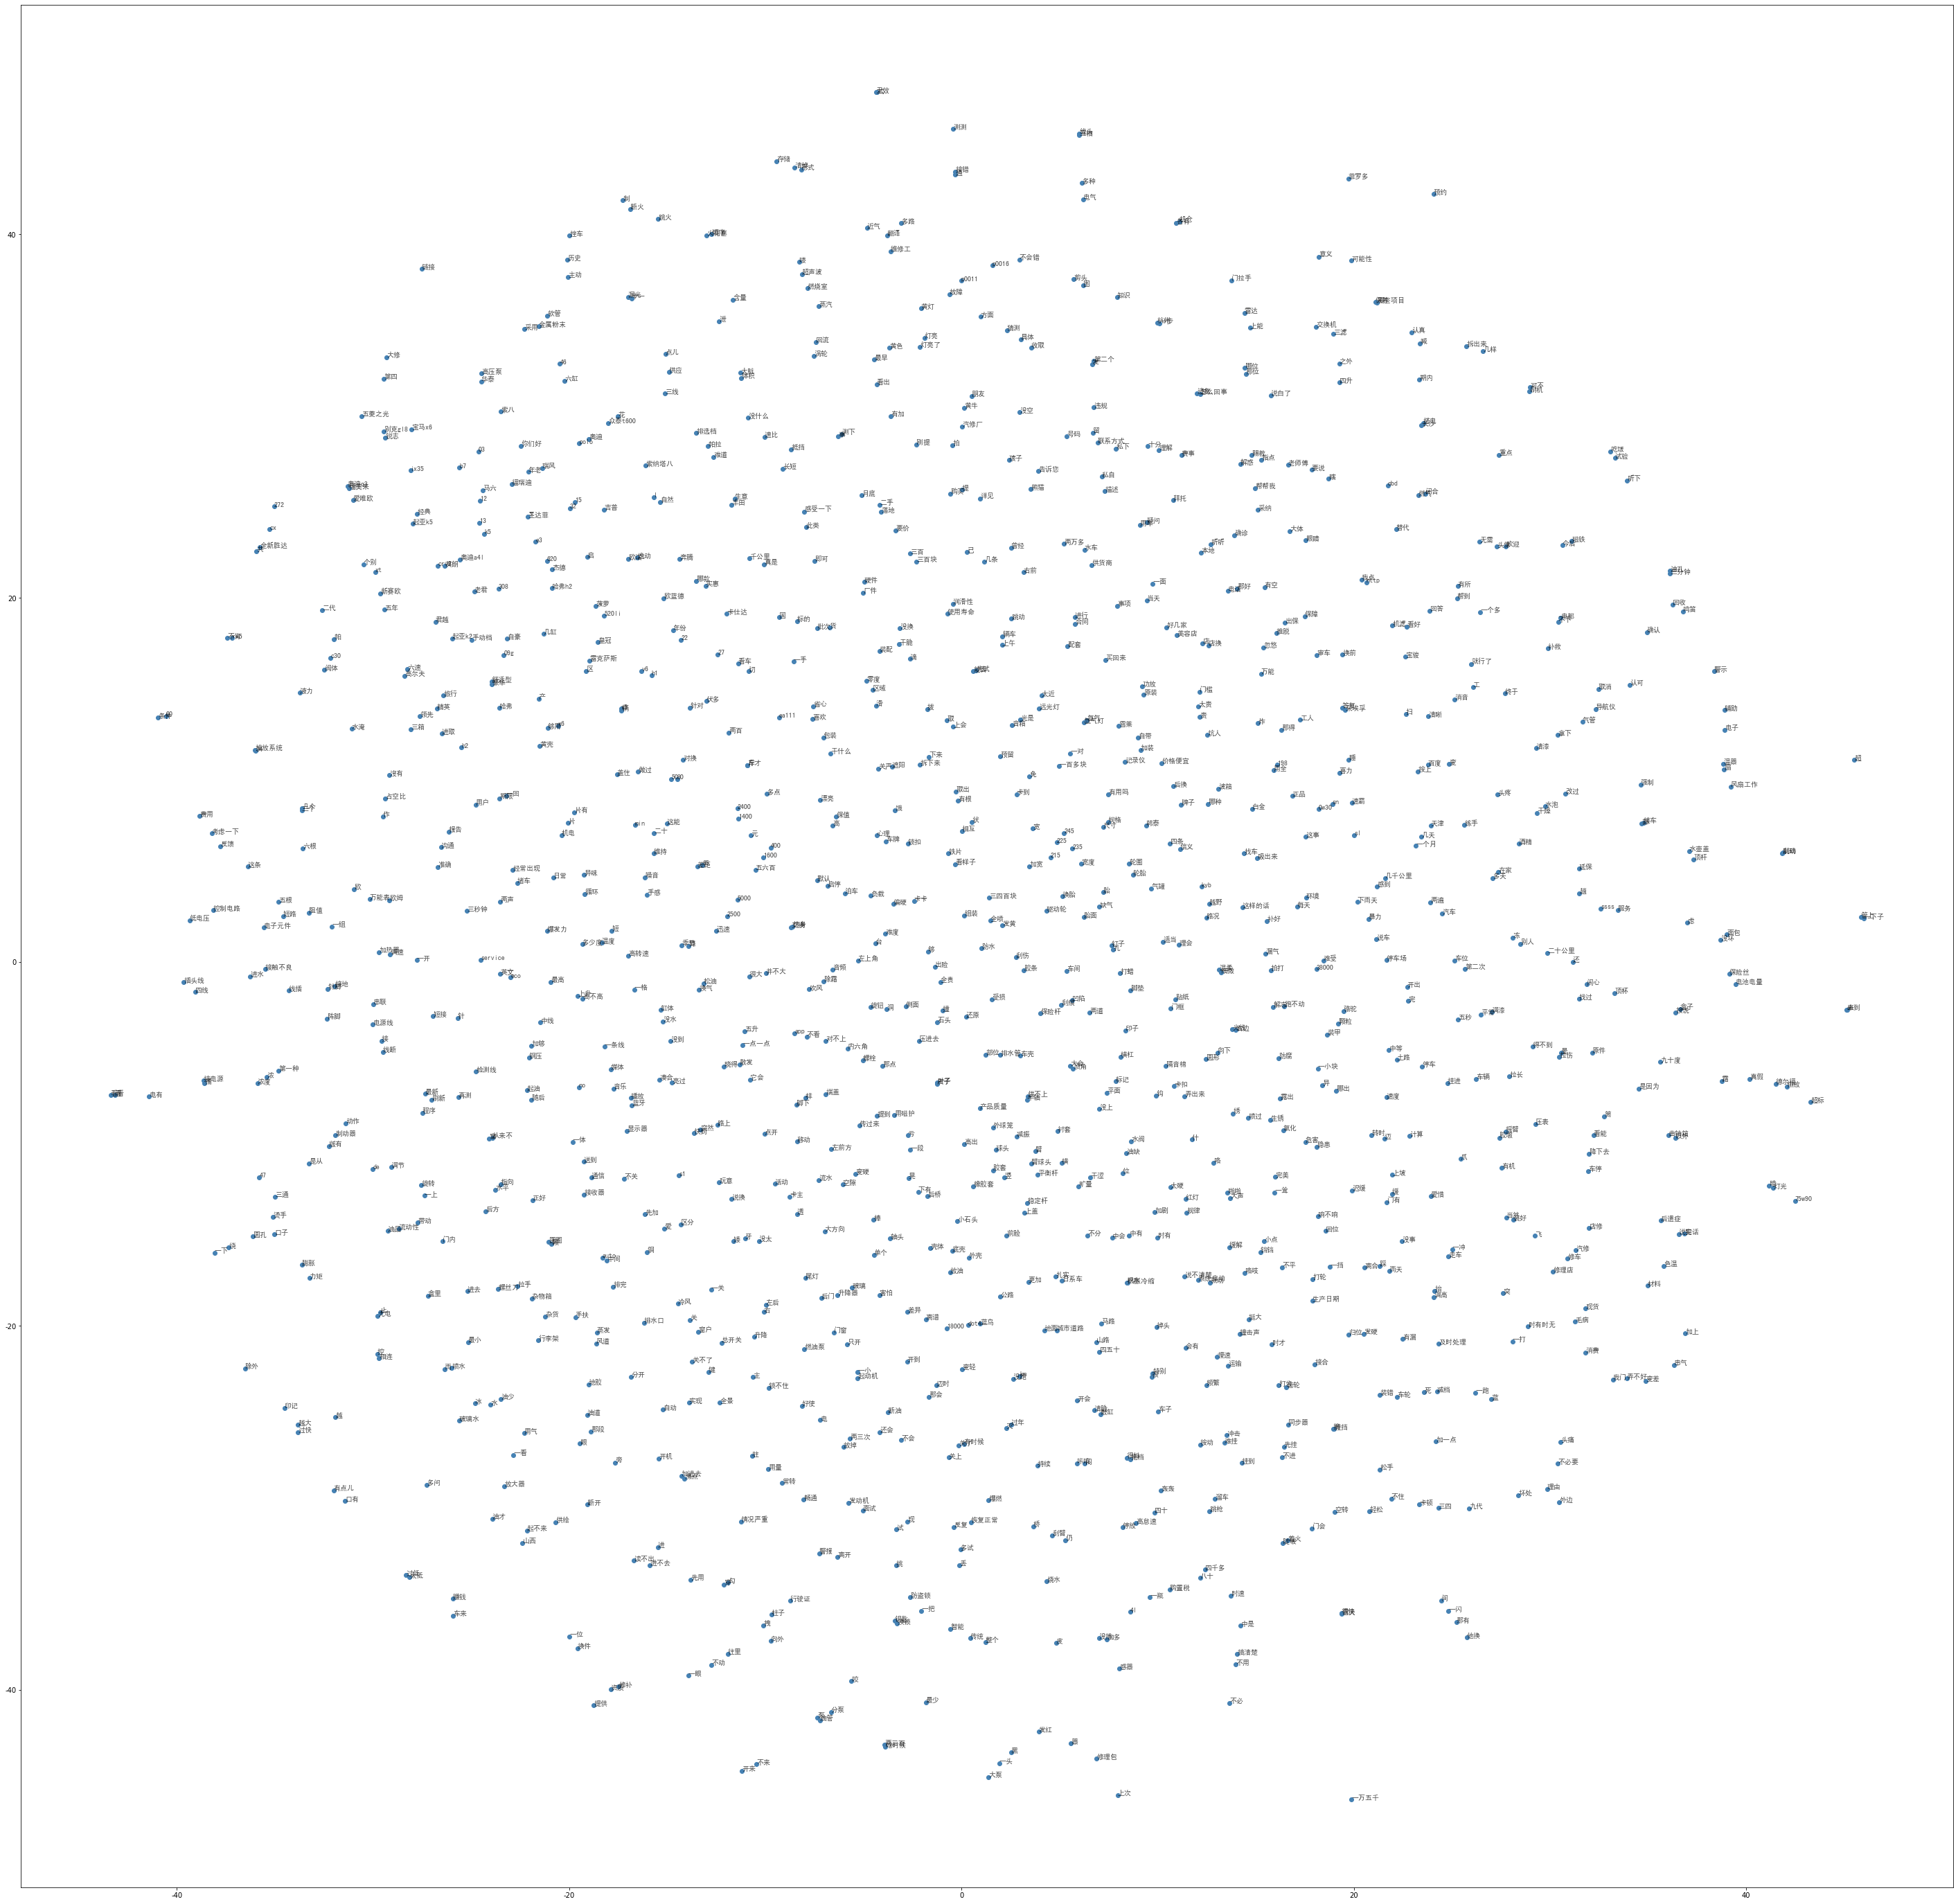

In [69]:
fig, ax = plt.subplots(figsize=(50, 50))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7,fontproperties=font)

In [ ]:
fig.savefig('auto_master.png')